In [1]:
# Import necessary libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import fetch_openml # MNIST data
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
# %matplotlib inline

## [1] MNIST - regression
Logistic regression and regularisation. 
* Using the SGDClassifer and the LogisticRegression, we build classifers for the MNIST dataset.  
* We find some handwritten digits which the classifers are not capable of classifying correctly. How do they differ from correctly classifed digits?  
* We scan over hyper-parameters (i.e. l1, l2 regularisation, different optimisers) and compare the
performance.  
* Lastly compare results to results we would have obtained by pure random guessing.

### Solution

In [2]:
# Code adapted from the "A high-bias, low-variance introduction to Machine Learning for physicists" review by Mehta et al.
### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


We have $70 000$ flattened images of size $28\times28$, and a label for each.

In [3]:
# Focus on a portion only (for speed)
train_size = 10000
test_size = 2000

# shuffle data and extract the portion.
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
# X = X[permutation]
# y = y[permutation]
X = X.iloc[permutation]
y = y.iloc[permutation]

# pick training and test data sets in this portion (note that this reshuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size)
print(np.max(X_train))
# scale data to have zero mean and unit variance 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit AND transform
X_test = scaler.transform(X_test) ## DO NOT REFIT: WE WANT THE SAME SCALING FOR BOTH DATASETS!!
print(np.max(X_train))

255
99.99499987499378


In [4]:
def log_classify(reg_strength=1e4, print_res = True, **kwargs):
    t0 = time.time()
    # apply logistic regressor with 'sag' solver, C is the inverse regularization strength
    clf = linear_model.LogisticRegression(C=reg_strength, **kwargs)
    # fit data
    clf.fit(X_train, y_train) ## This uses a solver because non-linear problem!!
    # percentage of nonzero weights
    sparsity = np.mean(clf.coef_ == 0) * 100
    # compute accuracy
    score = clf.score(X_test, y_test)

    #display run time
    run_time = time.time() - t0
    if print_res:
        print('Example run in %.3f s' % run_time)
        print("Sparsity: %.2f%%" % sparsity)
        print("Testscore: %.4f" % score)
    return clf, score

In [5]:
log_model, score = log_classify(multi_class='multinomial', penalty='l2', solver='sag', tol=1e-2) #Note that multinomial regression is 

c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Example run in 11.866 s
Sparsity: 14.03%
Testscore: 0.8965


What is the score? It is the accuracy, which is not the same as the loss!!

In [6]:
# SGDClassifier

def SGD_classify(print_res = True, **kwargs):
    t0 = time.time()
    clf = linear_model.SGDClassifier(**kwargs)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    #display run time
    run_time = time.time() - t0
    if print_res:
        print('Example run in %.3f s' % run_time)
        print("Testscore: %.4f" % score)
    return clf, score

In [7]:
SGD_model, score = SGD_classify(loss='log_loss', max_iter=100, tol=1e-5)

Example run in 16.203 s
Testscore: 0.9040


c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


What is the difference between SGD and LogisticRegression? The former has the latter but also many more loss functions. But the latter has also newtonian solvers.

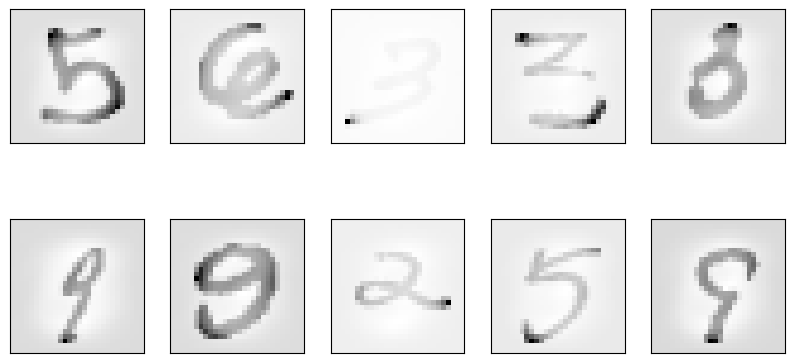

In [8]:
# Find examples that were not classified correctly:

# We use a boolean mask to get those which were not classified correctly
mask = (log_model.predict(X_test) != y_test)
X_false = X_test[mask]


#plot a few next to each other
plt.figure(figsize=(10, 5))
for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(X_false[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
#plt.subplots_adjust(wspace=-0.8,hspace=0, left=0,right=0.5)

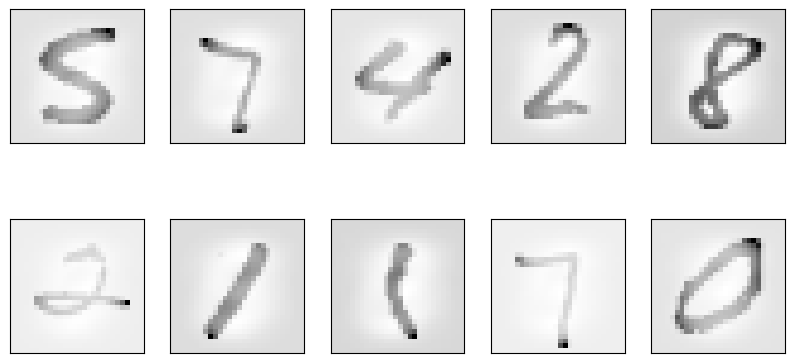

In [9]:
# Compare to correctly classified ones

# We use a boolean mask to get those which were classified correctly
mask = (log_model.predict(X_test) == y_test)
X_true = X_test[mask]


#plot a few next to each other
plt.figure(figsize=(10, 5))
for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(X_true[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())

We see that those numbers with a lot of straight lines are easier to classify than the ones with loops. The performance on the number 8 seems to be particularly bad. Let's quantify this:

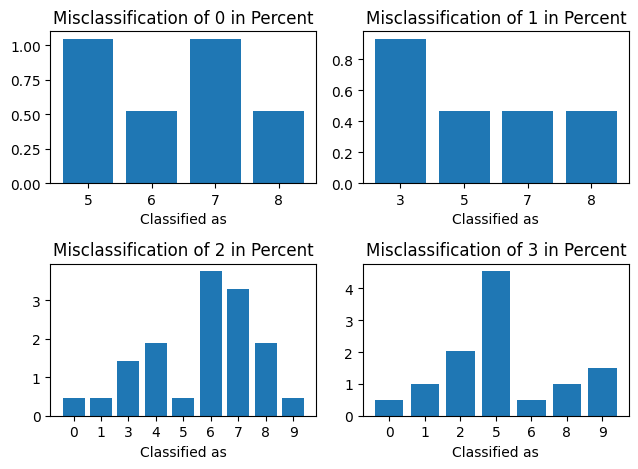

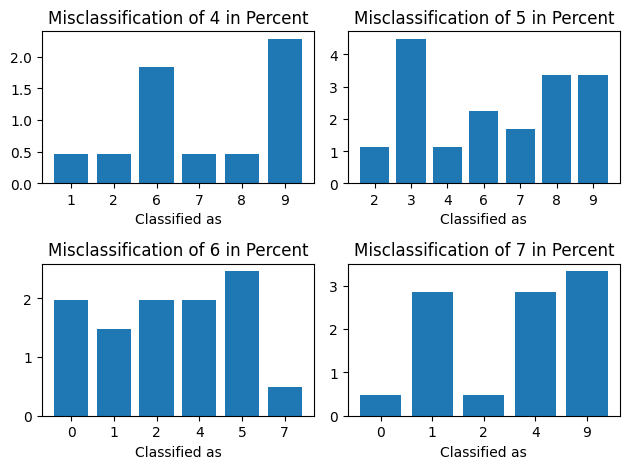

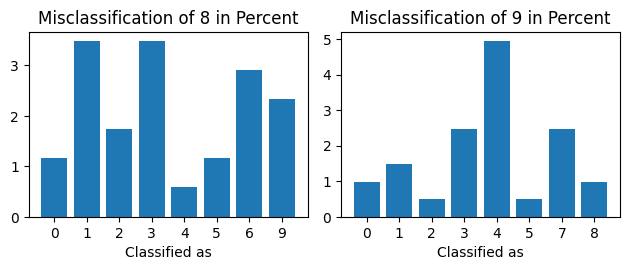

In [10]:
# again we use boolean masking to extract the number of wrongly predited digits.

plt.figure()
for i in range(4):
    prediction_per_class = log_model.predict(X_test)[y_test==str(i)]
    unique, counts = np.unique(prediction_per_class, return_counts=True)
    plt.subplot(2, 2, i+1)
    plt.bar(unique[unique!=str(i)], 100*counts[unique!=str(i)]/len(prediction_per_class))
    plt.title('Misclassification of ' + str(i) + ' in Percent')
    plt.xlabel('Classified as')
plt.tight_layout()

plt.figure()
for i in range(4,8):
    prediction_per_class = log_model.predict(X_test)[y_test==str(i)]
    unique, counts = np.unique(prediction_per_class, return_counts=True)
    plt.subplot(2, 2, i-3)
    plt.bar(unique[unique!=str(i)], 100*counts[unique!=str(i)]/len(prediction_per_class))
    plt.title('Misclassification of ' + str(i) + ' in Percent')
    plt.xlabel('Classified as')
plt.tight_layout()

plt.figure()
for i in range(8,10):
    prediction_per_class = log_model.predict(X_test)[y_test==str(i)]
    unique, counts = np.unique(prediction_per_class, return_counts=True)
    plt.subplot(2, 2, i-7)
    plt.bar(unique[unique!=str(i)], 100*counts[unique!=str(i)]/len(prediction_per_class))
    plt.title('Misclassification of ' + str(i) + ' in Percent')
    plt.xlabel('Classified as')
plt.tight_layout()

We see that 9,8 and 5 are very problematic. 1 is the easiest to classify (intuitively obvious).

Now try L1 regularization

In [11]:
# we use the saga solver because it supports l1 regularization
log_classify(reg_strength=1e4, multi_class='multinomial', penalty='l1', solver='saga', tol=1e-2)

c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Example run in 37.952 s
Sparsity: 14.03%
Testscore: 0.8960


(LogisticRegression(C=10000.0, multi_class='multinomial', penalty='l1',
                    solver='saga', tol=0.01),
 0.896)

We see that there is no significant difference. Let's try other choices of solvers. Supported are (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’)

In [12]:
log_classify(reg_strength=1e4, multi_class='ovr', penalty='l2', solver='liblinear', tol=1e-2)

c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Example run in 87.580 s
Sparsity: 14.03%
Testscore: 0.8330


(LogisticRegression(C=10000.0, multi_class='ovr', solver='liblinear', tol=0.01),
 0.833)

Runtime is significantly longer. The result is also significantly worse.

In [13]:
log_classify(reg_strength=1e4, multi_class='multinomial', penalty='l2', solver='newton-cg', tol=1e-2)

c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Example run in 0.394 s
Sparsity: 14.03%
Testscore: 0.8960


(LogisticRegression(C=10000.0, multi_class='multinomial', solver='newton-cg',
                    tol=0.01),
 0.896)

Result is comparatively poor.

In [14]:
log_classify(reg_strength=1e4, multi_class='multinomial', penalty='l2', solver='lbfgs', tol=1e-2)

Example run in 0.191 s
Sparsity: 14.03%
Testscore: 0.8855


c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(LogisticRegression(C=10000.0, multi_class='multinomial', tol=0.01), 0.8855)

This is quite fast but gives a poor result.

Of course we see that all of the results are much better than random guessing, which would have a 0.1 success rate.

## Let's try more hypertuning using a nice library: Optuna.

In [15]:
import optuna
import optuna.visualization as vis

c:\Users\yoann\OneDrive - University of Cambridge\PhD\Teaching\Mphil\ML M1\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:

def objective(trial):
    classifier_type = trial.suggest_categorical("classifier", ["SGD", "Logistic"])
    try:
        tol = trial.suggest_float("tol", 1e-5, 1e-1, log = True)
        penalty = trial.suggest_categorical("penalty", ["l2", "l1",None])
        if classifier_type == "SGD":
            alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log = True)
            max_iter = trial.suggest_int("max_iter", 100, 1000)
            clf, score = SGD_classify(print_res=False, alpha=alpha, max_iter=max_iter, tol=tol, penalty=penalty)
        
        else:  # Logistic
            reg_strength = trial.suggest_float("reg_strength", 1e-5, 1e5, log = True)
            solver = trial.suggest_categorical("solver", ["lbfgs", "saga", "newton-cg"])
            clf, score = log_classify(reg_strength=reg_strength, print_res=False, solver=solver, tol=tol, penalty=penalty, multi_class='multinomial')

        return score
    
    except Exception as e:
        return float("nan")  # Discard the trial


In [ ]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs = -1,show_progress_bar = True)

# Print best trial results
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


In [19]:
vis.plot_optimization_history(study)

Why Loss != Accuracy? 
- not much information about structure of fit